In [5]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import gdown
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import csv
import cv2
import itertools
import matplotlib.pyplot as plt
import skimage.feature as feature
import xlwings as xw
import torchvision.transforms as transforms

import random

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter, )

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
CSV_FILENAME = "final_eda_features.csv" #<-- update csv name
df_features = pd.read_csv(CSV_FILENAME)
df_features.head()

,Unnamed: 0.1,Unnamed: 0,path,updated_source_h,updated_source_w,face_index,used_mask,R_BIN_mask_0,R_BIN_mask_1,R_BIN_mask_2,...,SOBEL_BIN_bbox_14,SOBEL_BIN_bbox_15,SOBEL_BIN_bbox_16,SOBEL_BIN_bbox_17,SOBEL_BIN_bbox_18,SOBEL_BIN_bbox_19,x,y,w,h
0,0,0,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,683,1024,75,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.824519,0.508413,0.019231,0.021635
1,1,2,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,23,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.284856,0.522837,0.012019,0.016827
2,2,4,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,1,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.918269,0.612981,0.009615,0.014423
3,3,5,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,683,1024,2,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.602163,0.334135,0.055288,0.072115
4,4,6,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,632,1024,25,True,0.0,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.335337,0.486779,0.016827,0.021635


In [4]:
a = pd.read_csv("amos3_delivery_eda_features.csv")
a.head()

a = a.loc[:, a.columns.str.startswith("e_")]
a = a.mean()

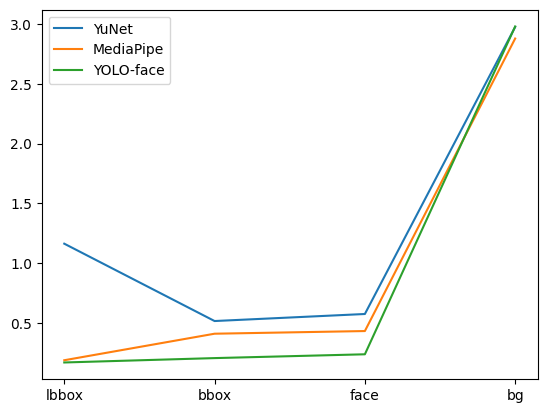

Index(['e_face_yn', 'e_face_mp', 'e_face_yf', 'e_bg_yn', 'e_bg_mp', 'e_bg_yf',
       'e_bbox_yn', 'e_bbox_mp', 'e_bbox_yf', 'e_lbbox_yn', 'e_lbbox_mp',
       'e_lbbox_yf'],
      dtype='object')

In [6]:
plt.plot(['lbbox', 'bbox', 'face', 'bg'], a[['e_lbbox_yn', 'e_bbox_yn', 'e_face_yn', 'e_bg_yn']], label="YuNet")
plt.plot(['lbbox', 'bbox', 'face', 'bg'], a[['e_lbbox_mp', 'e_bbox_mp', 'e_face_mp', 'e_bg_mp']], label="MediaPipe")
plt.plot(['lbbox', 'bbox', 'face', 'bg'], a[['e_lbbox_yf', 'e_bbox_yf', 'e_face_yf', 'e_bg_yf']], label="YOLO-face")
plt.legend()
plt.show()
a.index

In [6]:
import minepsilon as minE

In [7]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))

def save_tensor_as_image(image, path):
    save_img = cv2.cvtColor(np.moveaxis((image.detach().numpy() * 255).squeeze(), 0, -1).astype('uint8'), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, save_img)

In [8]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

epsilons = [0, .05]
use_cuda=True

torch.autograd.set_detect_anomaly(True)    
df = pd.DataFrame() # dataframe storing the dataset
row = {} #the information/columns for a single row in the dataset is stored here

# Loop over all examples in test set
INPUT_PATH = r"D:\Users\amosc\Documents\Coding\Thesis\THS-ST2\THS-ST1\images\Test"
CSV_PATH = os.path.join(INPUT_PATH, 'yuh.csv')

faces_df = pd.read_csv(CSV_PATH)
faces_df.loc[:, ["x1", "y1", "x2", "y2", "x1_pad", "y1_pad", "x2_pad", "y2_pad"]] = faces_df.loc[:, ["x1", "y1", "x2", "y2", "x1_pad", "y1_pad", "x2_pad", "y2_pad"]].clip(lower = 0)

path = os.path.join(INPUT_PATH, 'zeros.png')
row['path'] = path
file_basename = os.path.basename(path)
print(file_basename)

model.eval()

model.gradient_mode = False
for yolo_layer in model.yolo_layers:
    yolo_layer.gradient_mode = False

# read and transform the image from the path
data = cv2.imread(path)  # read the image
row['source_w'], row['source_h'], _ = data.shape
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image

with torch.no_grad():
    # Forward pass the data through the model and call non max suppression
    nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

face_list = []
if type(nms_output[0]) is not int:
    face_list = nms_output[0]

data = data.to(device)
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

model.gradient_mode = True
for yolo_layer in model.yolo_layers:
    yolo_layer.gradient_mode = True

output = model(data)

CUDA Available:  False
zeros.png


In [ ]:
# loop through each of the faces in the image
for face_index, face_row in enumerate(face_list): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time

    row['face_index'] = face_index
    print("Face", face_index)

    x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]

    factor_x, factor_y, factor_w, factor_h = random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2)
    normal_x, normal_y, normal_w, normal_h = x / 416, y / 416, w / 416, h / 416

    new_x = normal_x * factor_x if random.choice([True, False]) else normal_x / factor_x
    new_y = normal_y * factor_y if random.choice([True, False]) else normal_y / factor_y
    new_w = normal_w * factor_w if random.choice([True, False]) else normal_w / factor_w
    new_h = normal_h * factor_h if random.choice([True, False]) else normal_h / factor_h

    new_x, new_y, new_w, new_h = max(min(1, new_x), 0), max(min(1, new_y), 0), max(min(1, new_w), 0), max(min(1, new_h), 0)

    target = torch.tensor([[0.0, 0, new_x, new_y, new_w, new_h]])
    target = target.to(device)

    loss, loss_components = compute_loss(output, target, model)

    # cropped image with bounding box
    # getting (x1, y1) upper left, (x2, y2) lower right
    x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
    y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
    x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
    y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

    row['x1'], row['y1'], row['x2'], row['y2'] = x1, y1, x2, y2

    cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
    cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)

    # Zero all existing gradients
    model.zero_grad()
    data.grad = None

    # Calculate gradients of model in backward pass
    loss.backward(retain_graph=True) #TODO: Amos - check if this is correct

    # Collect datagrad
    data_grad = data.grad.data
    #print('Gradient')
    #print(data_grad)
    #print(data_grad.shape)
    #plt.imshow(np.transpose(np.clip(data_grad.squeeze(0).numpy(), 0, 1), (1, 2, 0)))
    #plt.show()

    bbox = (x1, y1, x2, y2)
    mask, used_mask = load_mask("restored_mask_8_Election_Campain_Election_Campaign_8_524_0_image_final.png", bbox)
    row['used_mask'] = used_mask
    print("MASK SHAPE:", mask.shape)

    #TODO: Jay - extract image attributes here
    # extract the image attributes from  the 'cropped_image' variable
    # save the attributes as row['<column name in the dataset>'] = <data> (see examples above for reference)

#     row = extract_image_attributes(row, path, face_index, cropped_image * tensor_to_image(mask[0]), "mask")
#     row = extract_image_attributes(row, path, face_index, cropped_image, "bbox")

#             whole_mask = np.zeros(data.shape)
#             whole_mask[..., y1:y2, x1:x2] = mask
#             inverted_mask = np.zeros(data.shape)
#             inverted_mask[..., y1:y2, x1:x2] = (1 - whole_mask[..., y1:y2, x1:x2]) if used_mask else whole_mask[..., y1:y2, x1:x2]

#             #print("bbox dim:", bbox)
#             #print(mask.shape, data[:, :, y1:y2, x1:x2].shape)
#             # TODO - Amos - determine the value of epsilon by calling fgsm_attack and changing the value of epsilon (see code below)
#             # the value of data(image) and data_grad remains constant diba

#             #print("Calculating min epsilon for YuNet...")
#             yn_min_e_face = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, whole_mask, bbox)
#             #print("Calculating min epsilon for MediaPipe...")
#             mp_min_e_face = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, whole_mask, bbox)
#             #print("Calculating min epsilon for YoloFace...")
#             yf_min_e_face = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, whole_mask, bbox)
#             print("yn min face:", yn_min_e_face, "mp min face:", mp_min_e_face, "yf min face:", yf_min_e_face)

#             row['e_face_yn'], row['e_face_mp'], row['e_face_yf'] = yn_min_e_face, mp_min_e_face, yf_min_e_face

#             if used_mask:
#                 yn_min_e_bg = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, inverted_mask, bbox)
#                 mp_min_e_bg = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, inverted_mask, bbox)
#                 yf_min_e_bg = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, inverted_mask, bbox)
#             else:
#                 yn_min_e_bg = yn_min_e_face
#                 mp_min_e_bg = mp_min_e_face
#                 yf_min_e_bg = yf_min_e_face

#             print("yn min bg:", yn_min_e_bg, "mp min bg:", mp_min_e_bg, "yf min bg:", yf_min_e_bg, "used mask" if used_mask else "did not use mask")
#             row['e_bg_yn'], row['e_bg_mp'], row['e_bg_yf'] = yn_min_e_bg, mp_min_e_bg, yf_min_e_bg

    bbox_mask = torch.from_numpy(np.zeros(data.shape))
    bbox_mask[..., y1:y2, x1:x2] = 1

#             if used_mask:
#     yn_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, bbox_mask, bbox)
#                 mp_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, bbox_mask, bbox)
#     yf_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, bbox_mask, bbox)
#             else:
#                 yn_min_e_bbox = yn_min_e_face
#                 mp_min_e_bbox = mp_min_e_face
#                 yf_min_e_bbox = yf_min_e_face

#             print("yn min bbox:", yn_min_e_bbox, "mp min bbox:", mp_min_e_bbox, "yf min bbox:", yf_min_e_bbox)
#             row['e_bbox_yn'], row['e_bbox_mp'], row['e_bbox_yf'] = yn_min_e_bbox, mp_min_e_bbox, yf_min_e_bbox

    large_x1 = max(int(np.floor((x - w).detach().cpu().numpy())), 0)
    large_y1 = max(int(np.floor((y - h).detach().cpu().numpy())), 0)
    large_x2 = min(int(np.ceil((x + w).detach().cpu().numpy())), 415)
    large_y2 = min(int(np.ceil((y + h).detach().cpu().numpy())), 415)

    large_bbox_mask = torch.from_numpy(np.zeros(data.shape))
    large_bbox_mask[..., large_y1:large_y2, large_x1:large_x2] = 1

    """print(bbox)
    print(large_x1, large_y1, large_x2, large_y2)

    plt.imshow(tensor_to_image(bbox_mask))
    plt.show()

    plt.imshow(tensor_to_image(large_bbox_mask))
    plt.show()"""
    yf_min_e_lbbox = minE.binary_search(0, 3, data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, large_bbox_mask, bbox)
    print("1:", yf_min_e_lbbox)

#     yn_min_e_lbbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, large_bbox_mask, bbox)
#     mp_min_e_lbbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, large_bbox_mask, bbox)
    yf_min_e_lbbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, large_bbox_mask, bbox)

#             print("yn min lbbox:", yn_min_e_lbbox, "mp min lbbox:", mp_min_e_lbbox, "yf min lbbox:", yf_min_e_lbbox)
#             row['e_lbbox_yn'], row['e_lbbox_mp'], row['e_lbbox_yf'] = yn_min_e_lbbox, mp_min_e_lbbox, yf_min_e_lbbox

#     cur_filename_base = os.path.join(INPUT_PATH, os.path.splitext(file_basename)[0] + "_" + str(face_index))

#             cur_filename =  cur_filename_base + "_yf_min_e_face.png"
#             save_tensor_as_image(minE.fgsm_attack(data.clone().detach(), yf_min_e_face, data_grad.clone().detach(), whole_mask), cur_filename)
#             cur_filename =  cur_filename_base + "_yf_min_e_bg.png"
#             save_tensor_as_image(minE.fgsm_attack(data.clone().detach(), yf_min_e_bg, data_grad.clone().detach(), inverted_mask), cur_filename)
    print("2:", yf_min_e_lbbox)
    
    cur_filename =  cur_filename_base + "_yn_min_e_bbox.png"
    save_tensor_as_image(minE.fgsm_attack(data.clone().detach(), yn_min_e_bbox, data_grad.clone().detach(), bbox_mask), cur_filename)
    cur_filename =  cur_filename_base + "_yn_min_e_lbbox.png"
    save_tensor_as_image(minE.fgsm_attack(data.clone().detach(), yn_min_e_lbbox, data_grad.clone().detach(), large_bbox_mask), cur_filename)
    
    
    
#     print("bbox e:", yn_min_e_bbox, "lbbox e:", yn_min_e_lbbox)

    # Call FGSM Attack

    #perturbed_data = minE.fgsm_attack(data.clone().detach(), yf_min_e, data_grad.clone().detach(), mask, *bbox)
    #perturbed_data = fgsm_attack(data, max(yn_min_e, mp_min_e), data_grad) #data is the input image, epsilon
    #print("can detect faces on unperturbed img?", minE.mp_det_fn(data.detach()))
    #print(f"can detect faces on perturbed data with e={max(yn_min_e, mp_min_e) - 0.01}?", minE.mp_det_fn(fgsm_attack(data, max(yn_min_e, mp_min_e) - 0.01, data_grad).detach()))
    #print(f"can detect faces on perturbed img? with e={max(yn_min_e, mp_min_e) - 0.01}", minE.mp_det_fn(perturbed_data.detach()))

    df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


Face 0
mask size before: torch.Size([1, 3, 415, 415])
x1, y1, orig shape
0 0 415 415
(415, 415)
yoloshape: 443 336
first diff: 0.0 0.0
False torch.Size([1, 3, 415, 415]) (415, 415) (415, 335)
padding: [0, 35, 28, 44]
new dim: (387, 336)
second diff: 14.0 -0.5
mask size after: torch.Size([1, 3, 415, 415])
unpadded bbox: (1281    0
Name: x1, dtype: int64, 1281    35
Name: y1, dtype: int64, 1281    443
Name: x2, dtype: int64, 1281    371
Name: y2, dtype: int64)
adjusted padding: [-14, 36, 14, 44]
MASK SHAPE: torch.Size([1, 3, 335, 415])
1: 0.18900390625000002


In [ ]:
"""import torch.nn.functional as F
source = torch.rand((5,8))
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
result = F.pad(input=source, pad=(0, 1, -1, -1), mode='constant', value=0)
print(source)
result"""

In [10]:
def load_mask(filename, target_bbox):
    mask = cv2.imread(os.path.join(os.getcwd(), INPUT_PATH, filename), 0)
    
    face_row = faces_df.loc[faces_df['filename'] == filename]
    padded_dim = (int(face_row["x2_pad"] - face_row["x1_pad"]), int(face_row["y2_pad"] - face_row["y1_pad"]))
    target_dim = (int(target_bbox[2] - target_bbox[0]), int(target_bbox[3] - target_bbox[1]))
    
    #print(dict(zip(*np.unique(mask, return_counts = True)))[255], int(target_dim[0] * target_dim[1] * 0.1))
    #print(dict(zip(*np.unique(mask, return_counts = True)))[255] < int(target_dim[0] * target_dim[1] * 0.1))
    
    if dict(zip(*np.unique(mask, return_counts = True)))[255] < int(target_dim[0] * target_dim[1] * 0.1):
        return torch.ones((1, 3, target_dim[1], target_dim[0])), False
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(mask.shape[0] * 0.5), int(mask.shape[1] * 0.5)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask = transforms.Compose([DEFAULT_TRANSFORMS])((mask, np.zeros((1, 5))))[0].unsqueeze(0)
    
    #print(face_row)
    
    #print(os.path.join(os.getcwd(), RESTORED_MASK_PATH, filename))
    print("mask size before:", mask.shape)
    
    print("x1, y1, orig shape")
    print(int(face_row["x1_pad"]), int(face_row["y1_pad"]), int(face_row["x2_pad"]), int(face_row["y2_pad"]))
    print(padded_dim)
    
    #print("target shape:", original_shape)
    print("yoloshape:", int(face_row["x2"] - face_row["x1"]), int(face_row["y2"] - face_row["y1"]))
    
    current_dim = max(mask.shape)
    diff_x, diff_y = abs(padded_dim[0] - current_dim) / 2, abs(padded_dim[1] - current_dim) / 2
    print("first diff:", diff_x, diff_y)
    
    if diff_y != 0:
        mask = mask[..., int(np.floor(diff_y)):-int(np.ceil(diff_y)), :]
    if diff_x != 0:
        mask = mask[..., int(np.floor(diff_x)):-int(np.ceil(diff_x))]
        
    print(mask.shape == padded_dim, mask.shape, padded_dim, target_dim)
    
    padding = [
        int(abs(face_row["x1"] - face_row["x1_pad"])),
        int(abs(face_row["y1"] - face_row["y1_pad"])),
        int(abs(face_row["x2"] - face_row["x2_pad"])),
        int(abs(face_row["y2"] - face_row["y2_pad"]))
    ]
    
    print("padding:", padding)
    
    new_dim = padded_dim[0] - padding[0] - padding[2], padded_dim[1] - padding[1] - padding[3]
    diff_x, diff_y = (target_dim[0] - new_dim[0]) / 2, (target_dim[1] - new_dim[1]) / 2
    print("new dim:", new_dim)
    print("second diff:", diff_x, diff_y)
    
    padding[0] -= int(np.floor(diff_x))
    padding[1] -= int(np.floor(diff_y))
    padding[2] -= int(np.ceil(diff_x))
    padding[3] -= int(np.ceil(diff_y))
    
    print("mask size after:", mask.shape)
    print("unpadded bbox:", (face_row["x1"], face_row["y1"], face_row["x2"], face_row["y2"]))
    print("adjusted padding:", padding)
    
    actual_dim = torch.zeros((1, 3, target_dim[1], target_dim[0]))
    
    mask = F.pad(input=mask, pad=(-padding[0], -padding[2], -padding[1], -padding[3]), mode='constant', value=0)
    
    #mask = mask[..., padding[1]:-padding[3], padding[0]:-padding[2]]
    
    return mask, True

In [ ]:
trypath = os.path.join(INPUT_PATH, '334935304_3512222965724455_1965518849144669583_n_0_yn_min_e_lbbox.png')
tryim = cv2.imread(trypath)  # read the image
tryim = cv2.cvtColor(tryim, cv2.COLOR_BGR2RGB) #change to rgb
tryim = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((tryim, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
res = minE.yn_det_fn(tryim)
withbox = cv2.imread(trypath)
for i in res:
    withbox = cv2.rectangle(withbox, (i[0], i[1]), (i[2], i[3]), (255, 0, 0), 2)
plt.imshow(withbox)
plt.show()

In [ ]:
#res = minE.yn_det_fn(data)
withbox = cv2.imread(path)
for i in res:
    withbox = cv2.rectangle(withbox, (i[0], i[1]), (i[2], i[3]), (255, 0, 0), 2)
plt.imshow(withbox)
plt.show()
print(minE.closest_bbox(res, minE.yf_det_fn(data)[0]))

In [ ]:
trypath = os.path.join(INPUT_PATH, '334935304_3512222965724455_1965518849144669583_n.jpg')
tryim = cv2.imread(trypath)
yn_face_detector = cv2.FaceDetectorYN_create("onnx/face_detection_yunet_2022mar.onnx", "", (0, 0))
height, width, _ = tryim.shape
yn_face_detector.setInputSize((width, height))
yn_face_detector.setNMSThreshold(0.5)
yn_face_detector.setScoreThreshold(0.5)
_, tryfaces = yn_face_detector.detect(tryim)
tryfaces